In [1]:
import pandas as pd
import numpy as np

In [2]:
train_ = pd.read_csv("training_v2.csv")
predict_ = pd.read_csv("unlabeled.csv")

train_['label'] = 'train'
predict_['label'] = 'test'

train_.drop(['encounter_id', 'hospital_id', 'patient_id', 'icu_id', 'readmission_status'], inplace=True, axis=1)
predict_.drop(['encounter_id', 'hospital_id', 'patient_id', 'icu_id', 'readmission_status', 
'hospital_death'], inplace=True, axis=1)

print(train_.shape)
print(predict_.shape)

(91713, 182)
(39308, 181)


In [3]:
train_["height"] = np.where((train_.height.isna() & (train_.gender == 'F')), 160, train_["height"])
train_["height"] = np.where((train_.height.isna() & (train_.gender == 'M')), 180, train_["height"])
train_["height"] = np.where((train_.height.isna() & (train_.gender.isna())), 170, train_["height"])
train_["weight"] = np.where((train_.height.isna() & (train_.gender == 'F')), 65, train_["weight"])
train_["weight"] = np.where((train_.height.isna() & (train_.gender == 'M')), 82, train_["weight"])
train_["weight"] = np.where((train_.height.isna() & (train_.gender.isna())), 74, train_["weight"])

In [4]:
predict_["height"] = np.where((predict_.height.isna() & (predict_.gender == 'F')), 160, predict_["height"])
predict_["height"] = np.where((predict_.height.isna() & (predict_.gender == 'M')), 180, predict_["height"])
predict_["height"] = np.where((predict_.height.isna() & (predict_.gender.isna())), 170, predict_["height"])
predict_["weight"] = np.where((predict_.height.isna() & (predict_.gender == 'F')), 65, predict_["weight"])
predict_["weight"] = np.where((predict_.height.isna() & (predict_.gender == 'M')), 82, predict_["weight"])
predict_["weight"] = np.where((predict_.height.isna() & (predict_.gender.isna())), 74, predict_["weight"])

In [5]:
lst = train_.isna().sum() / len(train_)

p = pd.DataFrame(lst)

# When we reset the index, the old index is added as a column, and a new sequential index is used
p.reset_index(inplace=True)

p.columns = ['a', 'b']
low_count = p[p['b'] > 0.4]

todelete = low_count['a'].values

train_.drop(todelete, axis=1, inplace=True)
predict_.drop(todelete, axis=1, inplace=True)

train_.shape

(91713, 108)

In [6]:
train_.dropna(thresh=54, inplace=True)
train_.shape

(91580, 108)

In [7]:
train_test = pd.concat([train_, predict_], keys=['x', 'y'])
train_test.shape

(130888, 108)

In [9]:
dictionary_ = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
print(dictionary_.shape)

(188, 6)


In [10]:
integer_cols = []
binary_cols = []
numeric_cols = []
string_cols = []

for i in range(dictionary_.shape[0]):
    if dictionary_.loc[i, 'Data Type'] == 'integer':
        integer_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'binary':
        binary_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'numeric':
        numeric_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'string':
        string_cols.append(dictionary_.loc[i, 'Variable Name'])


In [11]:
for col_name in numeric_cols:
    if col_name in train_test.columns.to_list():
        train_test[col_name] = train_test.groupby(['ethnicity', 'gender'], sort=False)[col_name].apply(lambda x: 
        x.fillna(x.mean()))

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_test = imputer.fit_transform(train_test) 

train_test = pd.DataFrame(train_test, columns=train_.columns)

In [13]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

for col_name in string_cols:
    if col_name in train_test.columns.to_list():
        train_test[col_name] = enc.fit_transform(train_test[[col_name]])

In [ ]:
def get_bmi_category(bmi):
    if bmi != bmi:  # NaN
        return np.nan
    elif bmi < 18.5:  # Underweight
        return 'Underweight'
    elif bmi < 25:  # Healthy weight
        return 'Healthy weight'
    elif bmi < 30:  # Overweight
        return 'Overweight'
    else:  # Obese
        return 'Obese'    
    
train_test["bmi_cat"] = train_test["bmi"].apply(get_bmi_category)

# value_counts() function returns a Series containing counts of unique values. 
# The resulting object will be in descending order so that the first element is the most 
# frequently-occurring element.
train_test["bmi_cat"] = train_test["bmi_cat"].fillna(train_test["bmi_cat"].value_counts().index[0])

def get_blood_pressure_category(sysbp, diasbp):
    if ((sysbp < 90) & (diasbp < 60)):
        return 1  # Low blood pressure
    elif ((sysbp < 120) & (diasbp < 80)):
        return 2  # Normal
    elif ((sysbp < 140) & (diasbp < 90)):
        return 3  # Pre-Hypertension
    elif ((sysbp < 160) & (diasbp < 100)):
        return 4  # Stage 1 Hypertension
    else:
        return 5  # Stage 2 Hypertension

train_test['bp_cat'] = train_test[['d1_sysbp_max', 'd1_diasbp_max']].apply(
    lambda x: get_blood_pressure_category(x.d1_sysbp_max, x.d1_diasbp_max), axis=1)

train_test["bp_cat"] = train_test["bp_cat"].fillna(train_test["bp_cat"].value_counts().index[0])


In [14]:
# separate train and test
train = train_test[train_test['label'] == 'train']
predict = train_test[train_test['label'] == 'test']

train.reset_index(inplace=True)
train.drop(['label'], inplace=True, axis=1)

predict.reset_index(inplace=True)
predict.drop(['label'], inplace=True, axis=1)

train = train.astype('float32')
predict = predict.astype('float32')

print(train.shape)
print(predict.shape)

C:\Users\siddi\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(91580, 108)
(39308, 108)


In [15]:
num_feature = []

for col_name in numeric_cols:
    if col_name in train_test.columns.to_list():
        num_feature.append(col_name)

In [16]:
# Create correlation matrix
corr_matrix = train[num_feature].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

train.drop(to_drop, inplace=True, axis=1)
predict.drop(to_drop, inplace=True, axis=1)

print(train.shape)
print(predict.shape)

(91580, 71)
(39308, 71)


<ipython-input-16-aa439621f46a>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(train)

In [11]:
import plotly.express as px

fig = px.scatter(components, x=0, y=1, width=1000, height=1000)
fig.show()

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(train)

# select all rows that are not outliers
mask = yhat != -1
len(mask)

In [ ]:
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope(contamination=0.5)
yhat = ee.fit_predict(train)

mask = yhat != -1
len(mask)

In [16]:
train['hospital_death'].value_counts() / len(train)

0.0    0.913791
1.0    0.086209
Name: hospital_death, dtype: float64

In [17]:
y_train = train['hospital_death']

train.drop(['index', 'hospital_death'], inplace=True, axis=1)
predict.drop(['index', 'hospital_death'], inplace=True, axis=1)

cat_feature = []

for i, col_name in enumerate(train.columns.to_list()):
    if col_name not in numeric_cols:
        cat_feature.append(i)

In [18]:
from sklearn.model_selection import train_test_split

train_1, train_2, y_train_1, y_train_2 = train_test_split(train, y_train, test_size=0.5, stratify=y_train)
train_1_1, train_2_1, y_train_1_1, y_train_2_1 = train_test_split(train_1, y_train_1, test_size=0.5, 
stratify=y_train_1)
train_1_2, train_2_2, y_train_1_2, y_train_2_2 = train_test_split(train_2, y_train_2, test_size=0.5, 
stratify=y_train_1)

In [19]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=cat_feature)
train_1_1_res, y_1_1_res = sm.fit_resample(train_1_1, y_train_1_1)

In [20]:
train_2_1_res, y_2_1_res = sm.fit_resample(train_2_1, y_train_2_1)

In [21]:
train_1_2_res, y_1_2_res = sm.fit_resample(train_1_2, y_train_1_2)

In [22]:
train_2_2_res, y_2_2_res = sm.fit_resample(train_2_2, y_train_2_2)

In [23]:
print(y_1_1_res.value_counts() / len(y_1_1_res))
print(y_2_1_res.value_counts() / len(y_2_1_res))
print(y_1_2_res.value_counts() / len(y_1_2_res))
print(y_2_2_res.value_counts() / len(y_2_2_res))

0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64


In [24]:
train_res = pd.concat([train_1_1_res, train_2_1_res, train_1_2_res, train_2_2_res])
y_res = pd.concat([y_1_1_res, y_2_1_res, y_1_2_res, y_2_2_res])

print(train_res.shape)
print(y_res.shape)

(167370, 69)
(167370,)


In [25]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=50, contamination=.05)
outliers = lof.fit_predict(train_res)
mask = outliers != -1
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  8369, 159001], dtype=int64))

In [26]:
train_res = train_res.loc[mask]

In [28]:
y_res = y_res.loc[mask]

In [27]:
from sklearn.preprocessing import MinMaxScaler

num_feature = []

for col_name in numeric_cols:
    if col_name in train_res.columns.to_list():
        num_feature.append(col_name)

train_res[num_feature] = MinMaxScaler().fit_transform(train_res[num_feature])

In [29]:
train_res.to_pickle("train_dat.csv")
predict.to_pickle("predict_dat.csv")
y_res.to_pickle("y_dat.csv")

In [2]:
import pandas as pd

train = pd.read_pickle("train_dat.csv")
y = pd.read_pickle("y_dat.csv")
predict = pd.read_pickle("predict_dat.csv")

[0. 1.]


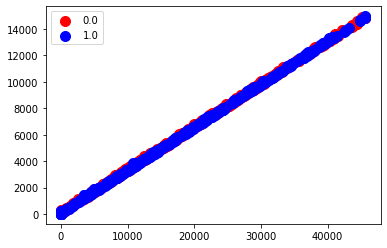

<Figure size 864x1296 with 0 Axes>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from metric_learn import NCA

y_tr = y
lf = NCA(n_components=2)
chosen_idx = np.random.choice(159001, size=1000)
X_train_metric = train.iloc[chosen_idx, :]
y_train_metric = y_tr.iloc[chosen_idx]
lf.fit(X_train_metric, y_train_metric)
X_transformed = lf.transform(X_train_metric)
#print(X_transformed)

[0. 1.]


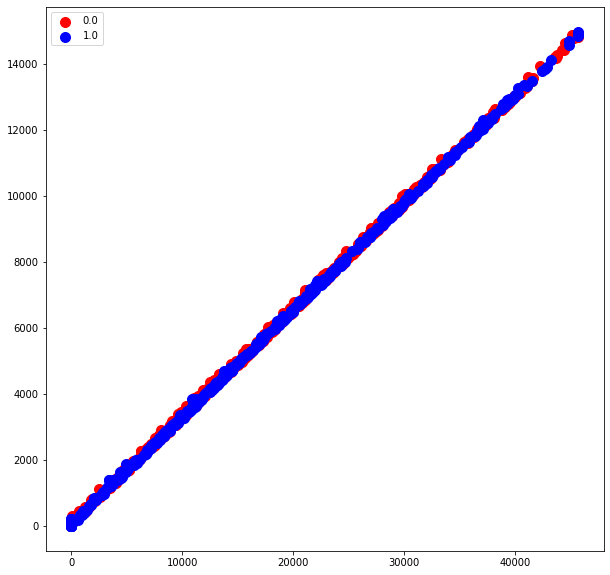

In [6]:
cdict = {0: 'red', 1: 'blue'}
fig, ax = plt.subplots(figsize=(10,10))
print(np.unique(y_train_metric))

for g in np.unique(y_train_metric):
    ix = np.where(y_train_metric == g)
    ax.scatter(X_transformed[ix,0], X_transformed[ix,1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()

Text(0.5, 0, 'Random Forest Feature Importance')

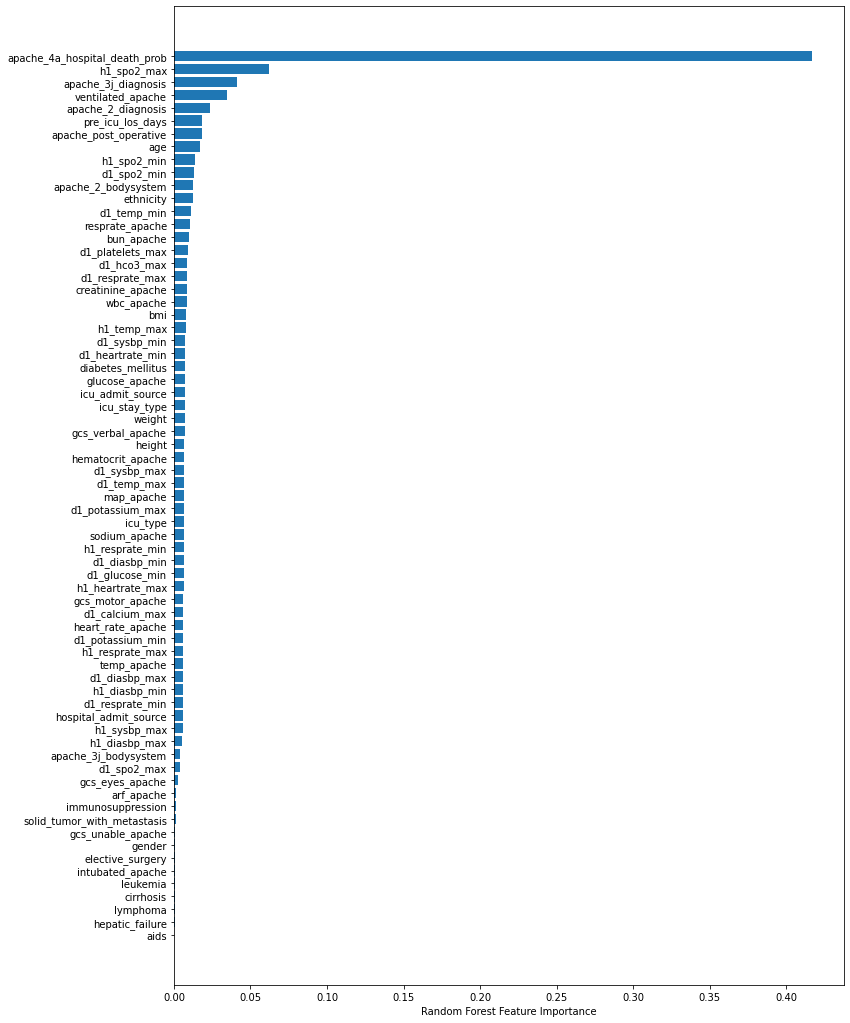

In [43]:
plt.figure(figsize=(12, 18))
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")